In [110]:
import tushare as ts
import seaborn as sns
import keras
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Dropout, Bidirectional
from keras.optimizers import RMSprop
from keras.initializers import Orthogonal
from tcn import TCN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    roc_auc_score, roc_curve, auc,
    confusion_matrix, recall_score, 
    precision_recall_fscore_support)
set_matplotlib_formats('retina')

In [2]:
ts.set_token('53cd3b985c649c978160c6ec04bce24f4fbd2ebcb4673e8f2fba9a43')

pro = ts.pro_api()

code_df = pro.stock_basic(exchange='', list_status='L', fields='ts_code')

C:\Users\GreenWood\Anaconda3\envs\tf_gpu_keras\lib\site-packages\tushare\util\upass.py:28: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  return str(df.ix[0]['token'])


In [3]:
use = ['Symbol', 'ContrshrProportion', 'IsRelatedTrading', 'ShareholderFirstProp',
       'ControlProportion', 'FamEntyp_1.0', 'FamEntyp_2.0', 'FamEntyp_3.0',
       'BoardCode_P3401', 'BoardCode_P3402', 'BoardCode_P3403', 'FamStyle_1',
       'FamStyle_2', 'ManGeneration_1.0', 'ManGeneration_2.0',
       'FamNameStatus_1', 'FamNameStatus_2', 'FamNameStatus_3',
       'FamNameStatus_4', 'FamNameStatus_5']
fam = pd.read_csv('data/family_firm_clean.csv', index_col=0, usecols=use)

In [4]:
pledge = pd.read_csv('data/pledge_clean.csv', index_col=0)
pledge['close_position_date'] = pd.to_datetime(pledge['close_position_date'])
pledge['pledge_date'] = pd.to_datetime(pledge['pledge_date'])

In [5]:
pledge = pledge.sort_values(by=['close_position_date'])
pledge = pledge.reset_index(drop=True)

In [6]:
pledge = pledge.merge(fam, how='left', left_on='code', right_on='Symbol')
pledge = pledge.fillna(0)

In [7]:
pledge.head(10)

,code,pledge_date,alarm_line,close_position_line,price_on_pledge,total_pledge_nb,total_share_ratio,total_stock_ratio,close_position_date,is_st,...,BoardCode_P3403,FamStyle_1,FamStyle_2,ManGeneration_1.0,ManGeneration_2.0,FamNameStatus_1,FamNameStatus_2,FamNameStatus_3,FamNameStatus_4,FamNameStatus_5
0,002280.SZ,2016-03-30,16.13,14.12,25.21,4471.250000,39.53000,2.050000,2016-12-14,0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
1,002280.SZ,2016-03-30,16.13,14.12,25.21,4471.250000,39.53000,2.050000,2016-12-14,0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
2,002280.SZ,2016-03-30,16.13,14.12,25.21,4471.250000,39.53000,2.050000,2016-12-14,0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
3,000796.SZ,2016-03-09,17.42,15.24,27.22,25525.720000,100.00000,31.790000,2016-12-20,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,000796.SZ,2016-01-18,17.42,15.24,27.22,23525.720000,92.16000,29.300000,2016-12-20,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,000796.SZ,2016-04-28,17.42,15.24,27.22,37910.007785,82.15942,18.559834,2016-12-20,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,000796.SZ,2016-04-28,17.42,15.24,27.22,37910.007785,82.15942,18.559834,2016-12-20,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,002147.SZ,2016-12-05,18.03,15.77,28.17,30280.580000,97.83000,34.080000,2017-01-16,0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
8,000503.SZ,2016-12-01,37.08,32.44,57.93,4214.180000,17.88000,4.690000,2017-04-12,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,000503.SZ,2016-12-07,34.50,30.18,53.90,17629.000000,70.97000,19.610000,2017-05-09,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
code_price_dict = dict()
for i in range(len(code_df)):
    code = code_df.iloc[i, 0]
    price_df = pd.read_csv('data/price/{}.csv'.format(code), index_col=0)
    price_df.index = pd.to_datetime(price_df.index)
    code_price_dict[code] = price_df

In [62]:
def get_stock_price_by_code(code, lookback, delay, pledge_date, close_position_date, code_price_dict, pledge_price):
    """
    通过股票代码，过去天数，生成三维的股票价格矩阵
    delay * lookback * 9(features)
    """
    scaler = MinMaxScaler()
    non_close_rate = 4
    step = 3
    price_df = code_price_dict[code]
    price_df = price_df.drop(['pre_close'], axis=1)
    price_df['delta'] = price_df.apply(lambda x: x['close'] - pledge_price, axis=1)
    price_df = price_df[pledge_date: close_position_date]
    price_values = scaler.fit_transform(price_df)
    # 平仓训练集
    usable_close_len = len(price_df) - lookback
    usable_close_len = min(usable_close_len, delay + 1)
    close_list = []
    for i in range(1, usable_close_len + 1, step):
        price_time = price_values[-lookback - i: -i]
        close_list.append(price_time)
    # 正常训练集
    usable_non_close_len = len(price_df) - delay - lookback
    usable_non_close_len = min(usable_non_close_len, non_close_rate * delay)
    non_close_list = []
    for i in range(delay+1, delay+1+usable_non_close_len, step):
        price_time = price_values[-lookback - i: -i]
        non_close_list.append(price_time)
        
    return close_list, non_close_list

In [10]:
pledge.drop(['code', 'pledge_date', 
             'close_position_date', 'total_pledge_nb', 
             'total_share_ratio', 'total_stock_ratio'], axis=1).head()

,alarm_line,close_position_line,price_on_pledge,is_st,ContrshrProportion,IsRelatedTrading,ShareholderFirstProp,ControlProportion,FamEntyp_1.0,FamEntyp_2.0,...,BoardCode_P3403,FamStyle_1,FamStyle_2,ManGeneration_1.0,ManGeneration_2.0,FamNameStatus_1,FamNameStatus_2,FamNameStatus_3,FamNameStatus_4,FamNameStatus_5
0,16.13,14.12,25.21,0,22.42,1.0,22.42,22.42,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
1,16.13,14.12,25.21,0,22.42,1.0,22.42,22.42,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
2,16.13,14.12,25.21,0,22.42,1.0,22.42,22.42,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
3,17.42,15.24,27.22,0,0.00,0.0,0.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17.42,15.24,27.22,0,0.00,0.0,0.00,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
def generator(pledge, lookback, delay, min_index, max_index, code_price_dict):
    # batch_size == delay(30)
    i = min_index
    all_zip = []
    # 归一化
    scaler = MinMaxScaler()
    pledge_scaled = pledge.drop(['code', 'pledge_date', 
                                 'close_position_date', 'total_pledge_nb', 
                                 'total_share_ratio', 'total_stock_ratio'], axis=1)
    pledge_scaled = scaler.fit_transform(pledge_scaled)
    while i < max_index:
        single_pledge = pledge.loc[i]
        single_pledge_scaled = pledge_scaled[i]
        close_list, non_close_list = get_stock_price_by_code(code=single_pledge['code'],
                               lookback=lookback,
                               delay=delay,
                               pledge_date=single_pledge['pledge_date'],
                               close_position_date=single_pledge['close_position_date'],
                               code_price_dict=code_price_dict,
                               pledge_price=single_pledge['price_on_pledge'])
        close_zip = [(prices, single_pledge_scaled, 1) for prices in close_list]
        non_close_zip = [(prices, single_pledge_scaled, 0) for prices in non_close_list]
        all_zip += close_zip + non_close_zip
        i += 1
    random.shuffle(all_zip)
    price_time = np.stack([t[0] for t in all_zip])
    pledge_info = np.stack([t[1] for t in all_zip])
    targets = np.stack([t[2] for t in all_zip])
    
    return price_time, pledge_info, targets

In [64]:
lookback = 48
delay = 30

train_price, train_info, train_targets = generator(pledge, lookback, delay, 0, 800, code_price_dict)
test_price, test_info, test_targets = generator(pledge, lookback, delay, 800, len(pledge), code_price_dict)

In [65]:
train_info.shape

(29468, 23)

In [66]:
train_price.shape

(29468, 48, 9)

In [15]:
def show_ratio(targets):
    unique, counts = np.unique(targets, return_counts=True)
    d = dict(zip(unique, counts))
    print(d)
    print(d[0] / (d[0] + d[1]))
    return d[0] / d[1]

In [67]:
weight_1 = show_ratio(train_targets)

{0: 21629, 1: 7839}
0.7339826252205782


In [68]:
show_ratio(test_targets)

{0: 4157, 1: 1575}
0.7252267969295185


2.6393650793650796

In [69]:
weight_1

2.759152953182804

In [77]:
def get_model(time_steps, price_dim, info_dim):
    price_input = Input(shape=(time_steps, price_dim), name='price_input')
    
#     lstm_out = Bidirectional(LSTM(16, 
#                     dropout=0.2,
#                     recurrent_dropout=0.5, 
#                     kernel_initializer=Orthogonal(seed=7),
#                     return_sequences=False
#                    ))(price_input)
    tcn_out = TCN(nb_filters=32, 
            kernel_size=3, 
            dilations=[1, 2, 4, 8, 16], 
            nb_stacks=1, 
            dropout_rate=0.3,
            kernel_initializer=Orthogonal(seed=7),
            return_sequences=False)(price_input)
#     price_con = keras.layers.concatenate([lstm_out, tcn_out])
#     price_out = Dense(16, activation='relu')(price_con)
#     price_out = Dropout(0.3)(price_out)
    
    info_input = Input(shape=(info_dim,), name='info_input')
    x = keras.layers.concatenate([tcn_out, info_input])
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(8, activation='relu')(x)
    output = Dense(1, activation='sigmoid', name='output')(x)
    
    model = Model(inputs=[price_input, info_input], outputs=[output])
    return model

In [78]:
model = get_model(time_steps=lookback, price_dim=train_price.shape[-1], info_dim=train_info.shape[-1])
model.compile(optimizer=RMSprop(decay=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
price_input (InputLayer)        (None, 48, 9)        0                                            
__________________________________________________________________________________________________
conv1d_129 (Conv1D)             (None, 48, 32)       320         price_input[0][0]                
__________________________________________________________________________________________________
conv1d_130 (Conv1D)             (None, 48, 32)       3104        conv1d_129[0][0]                 
__________________________________________________________________________________________________
activation_121 (Activation)     (None, 48, 32)       0           conv1d_130[0][0]                 
__________________________________________________________________________________________________
spatial_dr

In [79]:
class_weight = {
    0: 1,
    1: weight_1
}
history = model.fit([train_price, train_info], 
          train_targets, 
          epochs=50, 
          batch_size=64,
          validation_data=([test_price, test_info], test_targets),
#           class_weight=class_weight
                   )

Train on 29468 samples, validate on 5732 samples
Epoch 1/50
29468/29468 [==============================] - 14s 464us/step - loss: 0.5199 - acc: 0.7674 - val_loss: 0.5680 - val_acc: 0.7039
Epoch 2/50
29468/29468 [==============================] - 10s 332us/step - loss: 0.4733 - acc: 0.7962 - val_loss: 0.5410 - val_acc: 0.7135
Epoch 3/50
29468/29468 [==============================] - 10s 334us/step - loss: 0.4522 - acc: 0.8060 - val_loss: 0.5215 - val_acc: 0.7182
Epoch 4/50
29468/29468 [==============================] - 10s 335us/step - loss: 0.4362 - acc: 0.8119 - val_loss: 0.5699 - val_acc: 0.7189
Epoch 5/50
29468/29468 [==============================] - 10s 336us/step - loss: 0.4241 - acc: 0.8195 - val_loss: 0.5232 - val_acc: 0.7271
Epoch 6/50
29468/29468 [==============================] - 10s 337us/step - loss: 0.4152 - acc: 0.8242 - val_loss: 0.5558 - val_acc: 0.7128
Epoch 7/50
29468/29468 [==============================] - 10s 338us/step - loss: 0.4057 - acc: 0.8277 - val_loss: 0.5

In [22]:
def plot_loss(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

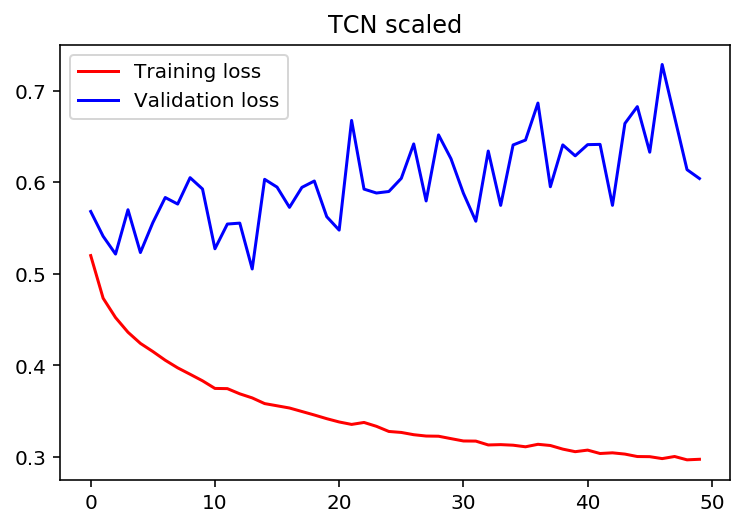

In [81]:
plot_loss(history, 'TCN scaled')

In [103]:
y_predict = model.predict([test_price, test_info]).ravel()
roc_auc_score(test_targets, y_predict)

0.8049706939146439

In [104]:
y_class = [1 if p > 0.5 else 0 for p in y_predict]
confusion_matrix(test_targets, y_class)

array([[3190,  967],
       [ 397, 1178]], dtype=int64)

In [105]:
unique, counts = np.unique(y_class, return_counts=True)
dict(zip(unique, counts))

{0: 3587, 1: 2145}

In [106]:
recall_score(test_targets, y_class)

0.7479365079365079

In [107]:
precision_recall_fscore_support(test_targets, y_class)

(array([0.88932255, 0.54918415]),
 array([0.76738032, 0.74793651]),
 array([0.82386364, 0.63333333]),
 array([4157, 1575], dtype=int64))

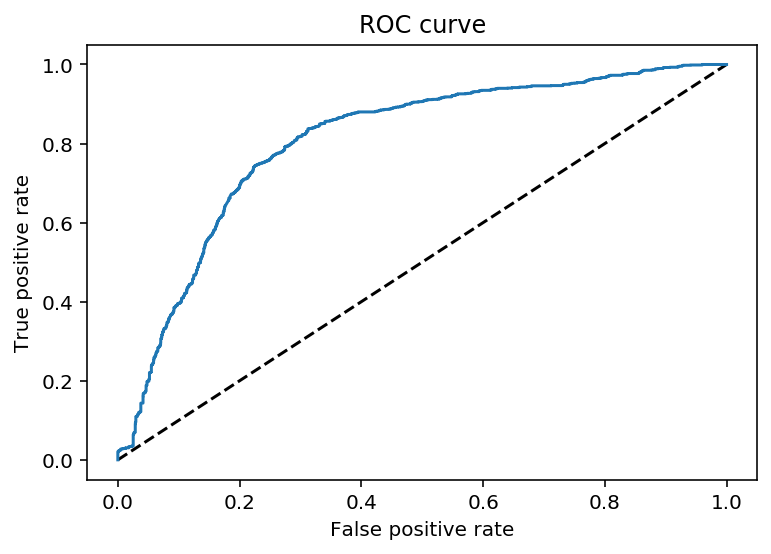

In [116]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_targets, y_predict)
auc_keras = auc(fpr_keras, tpr_keras)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [115]:
len(fpr_keras)

1980